In [38]:
import pprint
from pymongo import MongoClient
from bson.objectid import ObjectId

In [39]:
import numpy as np

In [40]:
from datetime import timedelta

In [41]:
import matplotlib.pyplot as plt

In [42]:
import pandas as pd

In [147]:
event_df = pd.read_csv('event_test.csv')

In [150]:
ans_list = event_df['pageType'].values

In [22]:
from datetime import datetime, tzinfo, timedelta
class simple_utc(tzinfo):
    def tzname(self,**kwargs):
        return "UTC"
    def utcoffset(self, dt):
        return timedelta(0)
datetime.utcnow().replace(tzinfo=simple_utc()).isoformat()

'2021-07-09T14:24:21.318568+00:00'

In [43]:
MONGO_USER = 'admin'
MONGO_PASSWORD = 'widmwidm9527'
MONGO_PORT = '27000'
HOST = 'localhost'
DATABASE = 'pageDB'
COLLECTION = 'queueResult'
# print(f"Loading settings, user:{MONGO_USER}, passwd:{MONGO_PASSWORD}")

MONGO_DETAILS = f"mongodb://{MONGO_USER}:{MONGO_PASSWORD}@{HOST}:{MONGO_PORT}"

client = MongoClient(MONGO_DETAILS)

database = client[DATABASE]

queue_collection = database.get_collection(COLLECTION)

In [24]:
queue_collection.find_one({})

{'_id': ObjectId('605969092f4eb5c53cefc879'),
 'tid': ObjectId('605969012f4eb5c53cefc878'),
 'url': 'http://www.tcsac.gov.tw/Activity/',
 'urls': [],
 'created_time': datetime.datetime(2021, 3, 23, 12, 5, 29, 603000)}

In [44]:
MONGO_USER = 'admin'
MONGO_PASSWORD = 'widmwidm9527'
MONGO_PORT = '27000'
HOST = 'localhost'
DATABASE = 'pageDB'
COLLECTION = 'autoExtractionResult'
# print(f"Loading settings, user:{MONGO_USER}, passwd:{MONGO_PASSWORD}")

MONGO_DETAILS = f"mongodb://{MONGO_USER}:{MONGO_PASSWORD}@{HOST}:{MONGO_PORT}"

client = MongoClient(MONGO_DETAILS)

database = client[DATABASE]

page_collection = database.get_collection(COLLECTION)

In [45]:
MONGO_USER = 'admin'
MONGO_PASSWORD = 'widmwidm9527'
MONGO_PORT = '27017'
HOST = '140.115.54.44'
DATABASE = 'ETL-api-creator'
COLLECTION_urls = 'autoExtractionUrls'
COLLECTION_extractors = 'extractors'

MONGO_DETAILS_ETL = f"mongodb://{MONGO_USER}:{MONGO_PASSWORD}@{HOST}:{MONGO_PORT}"

client_ETL = MongoClient(MONGO_DETAILS_ETL)

database_ETL = client_ETL[DATABASE]

etl_extractors_collection = database_ETL.get_collection(COLLECTION_extractors)
etl_aeUrls_collection = database_ETL.get_collection(COLLECTION_urls)

In [51]:
#large scale
start_day = datetime.strptime('2021-06-24 06:17','%Y-%m-%d %H:%M')
end_day = datetime.strptime('2021-06-24 23:11','%Y-%m-%d %H:%M')

In [47]:
#labeled data
'datetime.datetime(2021, 6, 16, 1, 53, 57, 950000)'
'datetime.datetime(2021, 6, 16, 2, 11, 00, 907000)'
start_day = datetime.strptime('2021-06-15 17:53:57','%Y-%m-%d %H:%M:%S')
end_day = datetime.strptime('2021-06-15 18:11:00','%Y-%m-%d %H:%M:%S')

In [48]:
#test
'2021-07-09T14:29:48.903329+00:00'
start_day = datetime.strptime('2021-07-09 14:29:45','%Y-%m-%d %H:%M:%S')
end_day = datetime.strptime('2021-07-09 14:35:09','%Y-%m-%d %H:%M:%S')

In [52]:
day_range = {
        "$gte": start_day,
        "$lt": end_day
}
print(day_range)

{'$gte': datetime.datetime(2021, 6, 24, 6, 17), '$lt': datetime.datetime(2021, 6, 24, 23, 11)}


In [58]:
Success_count = 0
Pass_count = 0
Failed_count = 0
created_extractors_sns = []
created_time_accm = []
predict_record = []
build_failed = []
predict_single = 0
predict_multi = 0
first = start_day
for post in page_collection.find({"createdDateTime": day_range}):
    queue_post = queue_collection.find_one({'tid': post['tid']})
    pageType = None
    if queue_post:
#         pprint.pprint(queue_post)
        if len(queue_post['urls']) == 0:
            predict_single+=1
            predict_record.append(1)
            pageType = "singleListPage"
        else:
            predict_multi+=1
            predict_record.append(0)
            pageType = "detailPage"
    if post['status'] != 'Failed':
        if post['status'] == 'Success':
            Success_count+=1
        else:
            Pass_count+=1
        etl_post = etl_extractors_collection.find_one({'serialNumber': post['serialNumber']})
        if etl_post:
            if pageType == 'detailPage' and len(etl_post['setsColumns']) < 2:
                build_failed.append(post['serialNumber'])
        created_extractors_sns.append(post['serialNumber'])
        created_time_accm.append({"time": (post['createdDateTime'] - first).total_seconds()/60,"accm": Success_count})
    else:
#         pprint.pprint(post)
        Failed_count+=1
print("Predicted: ", Success_count+Failed_count+Pass_count)
print("Success: ", Success_count)
print("Pass: ", Pass_count)
print("Failed: ", Failed_count)
print("===========================")
print("predict multi: ", predict_multi)
print("predict single: ", predict_single)

Predicted:  402
Success:  136
Pass:  216
Failed:  50
predict multi:  196
predict single:  206


In [59]:
build_failed

['3cvrjwh3ckqaimhkq',
 '3cvrjwh22kqaimoiv',
 '3cvrjwh3jkqain453',
 '3cvrjwh2hkqainpw2',
 '3cvrjwh2hkqainier',
 '3cvrjwh3jkqaio75k',
 '3cvrjwh22kqainzso',
 '3cvrjwh2akqaisrl9',
 '3cvrjwh1wkqaisybk',
 '3cvrjwh3jkqaiv6ur',
 '3cvrjwh1wkqaiuzt9',
 '3cvrjwh22kqaivnj6',
 '3cvrjwh22kqaivvxc',
 '3cvrjwh1wkqaixl2k',
 '3cvrjwh2pkqaiy6ot',
 '3cvrjwh3ckqaiydce',
 '3cvrjwh1wkqaiytnw',
 '3cvrjwh2wkqaj5u6e',
 '3cvrjwh3ckqaj6117',
 '3cvrjwh3jkqaj6ujt',
 '3cvrjwh2hkqaj7rt1',
 '3cvrjwh3ckqaj80m3',
 '3cvrjwh2hkqaj89zr',
 '3cvrjwh3jkqaj96rr',
 '3cvrjwh1wkqaj9fpi',
 '3cvrjwh22kqajat2p',
 '3cvrjwh1wkqajazlc',
 '3cvrjwh2pkqajb6ex',
 '3cvrjwh2wkqajbob0',
 '3cvrjwh22kqajbvhe',
 '3cvrjwh1wkqajcjv6',
 '3cvrjwh22kqajcwp5',
 '3cvrjwh2akqajd39l',
 '3cvrjwh2hkqaje4ml',
 '3cvrjwh22kqajfpz4',
 '3cvrjwh3jkqajguy2',
 '3cvrjwh2hkqajh3u2',
 '3cvrjwh2akqaji5wp',
 '3cvrjwh1wkqajicnk',
 '3cvrjwh2pkqajijei',
 '3cvrjwh3ckqajixd3',
 '3cvrjwh3ckqajjhvw',
 '3cvrjwh3ckqajjvdj',
 '3cvrjwh2pkqajl6ri',
 '3cvrjwh1wkqajler0',
 '3cvrjwh3

In [60]:
for sns in build_failed:
    api_origin = 'http://140.115.54.44:8001/extractors'
    print(f"{api_origin}/{sns}")

http://140.115.54.44:8001/extractors/3cvrjwh3ckqaimhkq
http://140.115.54.44:8001/extractors/3cvrjwh22kqaimoiv
http://140.115.54.44:8001/extractors/3cvrjwh3jkqain453
http://140.115.54.44:8001/extractors/3cvrjwh2hkqainpw2
http://140.115.54.44:8001/extractors/3cvrjwh2hkqainier
http://140.115.54.44:8001/extractors/3cvrjwh3jkqaio75k
http://140.115.54.44:8001/extractors/3cvrjwh22kqainzso
http://140.115.54.44:8001/extractors/3cvrjwh2akqaisrl9
http://140.115.54.44:8001/extractors/3cvrjwh1wkqaisybk
http://140.115.54.44:8001/extractors/3cvrjwh3jkqaiv6ur
http://140.115.54.44:8001/extractors/3cvrjwh1wkqaiuzt9
http://140.115.54.44:8001/extractors/3cvrjwh22kqaivnj6
http://140.115.54.44:8001/extractors/3cvrjwh22kqaivvxc
http://140.115.54.44:8001/extractors/3cvrjwh1wkqaixl2k
http://140.115.54.44:8001/extractors/3cvrjwh2pkqaiy6ot
http://140.115.54.44:8001/extractors/3cvrjwh3ckqaiydce
http://140.115.54.44:8001/extractors/3cvrjwh1wkqaiytnw
http://140.115.54.44:8001/extractors/3cvrjwh2wkqaj5u6e
http://140

In [154]:
len(predict_record)

100

In [159]:
predict_record = np.array(predict_record)

In [155]:
len(ans_list)

100

In [156]:
from sklearn.metrics import precision_recall_fscore_support

In [161]:
precision_recall_fscore_support(ans_list, predict_record, average='macro')

(0.7980769230769231, 0.801948051948052, 0.7987117552334944, None)

In [76]:
created_time_accm

[{'time': 2.4610666666666665, 'accm': 1},
 {'time': 2.4929833333333336, 'accm': 2},
 {'time': 2.5814666666666666, 'accm': 3},
 {'time': 2.7253499999999997, 'accm': 4},
 {'time': 3.0531833333333336, 'accm': 5},
 {'time': 3.1956166666666665, 'accm': 6},
 {'time': 3.696833333333333, 'accm': 7},
 {'time': 3.823, 'accm': 8},
 {'time': 4.042583333333334, 'accm': 9},
 {'time': 4.06835, 'accm': 10},
 {'time': 4.172583333333333, 'accm': 11},
 {'time': 4.1939166666666665, 'accm': 12},
 {'time': 4.404183333333333, 'accm': 13},
 {'time': 4.621700000000001, 'accm': 14},
 {'time': 4.798216666666666, 'accm': 15},
 {'time': 4.985566666666667, 'accm': 16},
 {'time': 5.165633333333333, 'accm': 17},
 {'time': 5.356066666666666, 'accm': 18},
 {'time': 5.538216666666667, 'accm': 19},
 {'time': 6.053333333333333, 'accm': 20},
 {'time': 6.336883333333334, 'accm': 21},
 {'time': 6.383516666666667, 'accm': 22},
 {'time': 6.503933333333333, 'accm': 23},
 {'time': 6.711016666666667, 'accm': 24},
 {'time': 7.1490

In [80]:
73.1992*60 / 352

12.477136363636363

Text(0, 0.5, 'Created Extractors')

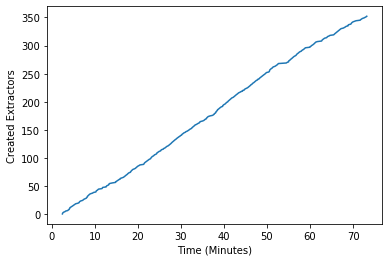

In [78]:
plt.plot([data['time'] for data in created_time_accm], [data['accm'] for data in created_time_accm])
plt.xlabel('Time (Minutes)')
plt.ylabel('Created Extractors')

In [58]:
extractors_stat = {
    "detailPage_count": 0,
    "detailPage_success": 0,
    "detailPage_failed": 0,
    "singlePage_count": 0,
    "singlePage_success": 0,
    "singlePage_failed": 0,
}
all_succ_ext = []
for _serialNumber in created_extractors_sns:
    post = etl_extractors_collection.find_one({"serialNumber":_serialNumber})
    if post['pageType'] == 'detailPage':
        extractors_stat['detailPage_count'] +=1
        if len(post['setsColumns']) > 1:
            extractors_stat['detailPage_success'] +=1
            all_succ_ext.append(_serialNumber)
        else:
            extractors_stat['detailPage_failed'] +=1
    elif post['pageType'] == 'singleListPage':
        extractors_stat['singlePage_count'] +=1
        if len(post['setsColumns']) > 0:
            extractors_stat['singlePage_success'] +=1
            all_succ_ext.append(_serialNumber)
        else:
            extractors_stat['singlePage_failed'] +=1
            
print("Summary stats: ", extractors_stat)

Summary stats:  {'detailPage_count': 150, 'detailPage_success': 45, 'detailPage_failed': 105, 'singlePage_count': 202, 'singlePage_success': 202, 'singlePage_failed': 0}


In [59]:
single_need_crawled = 0
detailPage_need_crawled = 0
single_urls = 0
multi_urls = 0
urls_count = 0
detail_succ=  set()
single_succ = set()
for _serialNumber in all_succ_ext:
    post = etl_aeUrls_collection.find_one({"serialNumber":_serialNumber})
    extractor = etl_extractors_collection.find_one({"serialNumber":_serialNumber})
    if post:
        if extractor['pageType'] == 'singleListPage':
            single_need_crawled+=1
            single_urls += len(post['urls'])
            single_succ.add(_serialNumber)
        else:
            detailPage_need_crawled+=1
            multi_urls += len(post['urls'])
            detail_succ.add(_serialNumber)
        urls_count += len(post['urls'])
    else:
        pass
print("Single need crawled: ", single_need_crawled)
print("Detail need crawled: ", detailPage_need_crawled)
print(f"Urls generated: {urls_count}, Single: {single_urls}, Multi: {multi_urls}")

Single need crawled:  156
Detail need crawled:  40
Urls generated: 4774, Single: 2616, Multi: 2158


In [10]:
post = etl_extractors_collection.find_one({"serialNumber":"3cvrjweyiko6tb52k"})

In [11]:
post['setsColumns']

[None]

In [12]:
len(post['setsColumns'])

1

In [151]:
len(post['setsColumns'][4])

4